In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import tensorflow as tf
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import find_peaks

np.random.seed(1337) # for reproducibility

def load_sensor(ramp_num, dir_path, sensor, time_range = None):
    """
    Load a sensor's data in the specified time range.
    
    Example usage: load_sensor("Ramp_7", "15T_data", 0, time_range = (-20,0))
    
    Args:
     - ramp_num (str): ramp number
     - dir_path (str): path to directory containing all the ramp's data
     - sensor (int): sensor index (0 or 1)
     - time_range (tuple): time range in which the data should be loaded
    
    Returns: The specified sensor in specified time range
    """
    
    needed_file = None
    
    #Scan the directory for correct ramp file
    for filename in os.listdir(dir_path):
        if filename.startswith(ramp_num):
            needed_file = dir_path + "/" + filename
            
    #Load the file
    f = h5py.File(needed_file,'r')
    data = np.array(f['chanvals'], dtype = 'float16')
    
    #Load time
    time_axis = np.load(dir_path + "/time_axis/" + ramp_num + "_time.npy")
    
    #Calculate index for selecting data
    selection_index = (time_axis > time_range[0]) & (time_axis < time_range[1])
    
    df_data = pd.DataFrame(data = {"dummy": data[sensor, :][selection_index]})
    
    #Return the sensor's data accoring to the index 
    return df_data["dummy"]
    
    %reset -f in
    
def load_time_label(ramp_num, dir_path, time_range = None, window = 2000, step = 10):
    """
    Load a ramp time axis in a specified range.
    
    Example usage: load_time_label("Ramp_7", "15T_data", time_range = (-20,0))
    
    Args:
     - ramp_num (str): ramp number
     - dir_path (str): path to directory containing all the ramp's data
     - time_range (tuple): time range in which the data should be loaded
    
    Returns: The specified time axis in specified time range
    """
    
    needed_file = None
    
    #Scan the directory for correct ramp file
    for filename in os.listdir(dir_path):
        if filename.startswith(ramp_num):
            needed_file = dir_path + "/" + filename
            
    #Load the file
    f = h5py.File(needed_file,'r')
    data = np.array(f['chanvals'], dtype = 'float16')
    
    #Load time
    time_axis = np.load(dir_path + "/time_axis/" + ramp_num + "_time.npy")
    
    #Calculate index for selecting data
    selection_index = (time_axis > time_range[0]) & (time_axis < time_range[1])
    
    %reset -f in
    
    return time_axis[selection_index][window-1::step]


#### Mean of abs(signal)
def generate_mean_data(ramp_num, dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(ramp_num, dir_path, 0, time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(ramp_num, dir_path, 1, time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(ramp_num, dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(ramp_num, dir_path, 0, time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(ramp_num, dir_path, 1, time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1, product)).transpose()
    
    %reset -f in
    
    return all_sd

def generate_data(ramp_num, dir_path, time_range, window = 2000, step = 10):
    
    #Selection index due to using different window
    #selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(ramp_num, dir_path, time_range, window = window, step = step)
    moving_sd = generate_sd_data(ramp_num, dir_path, time_range, window = window, step = step)
    time_label = load_time_label(ramp_num, dir_path, time_range, window = window, step = step)
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    print("All data's shape: ", all_data.shape)
    
    %reset -f in
    
    return all_data, time_label


############DYNAMIC LEARNING IMPLEMENTATION############
def create_threshold_list(trigger_sections, start_thres = 4.0, end_thres = 2.6):
    
    increment = (start_thres - end_thres)/(trigger_sections-3)
    
    trigger_thres = [0,0] #No trigger in the first two sections
    
    trigger_thres.extend([start_thres - i*increment for i in range(trigger_sections - 2)])
    
    return trigger_thres

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    # Simple model
    model = models.Sequential()

    model.add(Dense(4, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=6))

    model.add(Dense(2,activation='elu',
                    kernel_initializer='glorot_uniform', name = 'latent_space'))

    model.add(Dense(4,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')


    return model

def get_latent_output(model_weights, X):
    
    model = create_model()  # create the original model
    model.set_weights(model_weights)

    layer_name = 'latent_space'
    intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_layer_model.compile(loss='mse',optimizer='adam')
    
    intermediate_output = intermediate_layer_model.predict(X)
    
    return intermediate_output

def train(current_weights, X, time_axis, time_range):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_train = np.copy(X[start_index:end_index])
    time_train = time_axis[start_index:end_index]
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Scaler initiation
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=30, verbose = 0)
    
    new_weights = model.get_weights()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    #Plot the reconstruction loss
    plt.figure(figsize=(20,2))
    plt.plot(time_train, loss)
    plt.title("TRAINING reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Take the mean of the log loss and update the mean threshold
    current_median = np.median(np.log10(loss))
    
    print("Finished training, median of the log(loss) is: ", current_median)
    
    return new_weights, current_median, scaler

def plot_input_reconstructed(time_axis, X_test, reconstructed):
    
    for i in range(X_test.shape[1]):
        plt.figure(figsize=(20,2))
        plt.plot(time_axis, X_test[:,i], label = "Signal Input")
        plt.plot(time_axis, reconstructed[:,i], label = "Reconstructed Output")
        plt.legend(loc = "best", fontsize = 13)
        plt.show()
        

def trigger(trigger_threshold, current_weights, X, time_axis, time_range, prev_median, scaler):
    
    print("Triggering for section: ", time_range)
    print("Using this median for triggering:", prev_median)
    print("Triggering threshold is: ", trigger_threshold)
    
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    time_test = time_axis[start_index:end_index]
    X_test = np.copy(X[start_index:end_index])
    
    X_test = scaler.transform(X_test) #Scale the current data
    
    #Create model
    model = create_model()
    model.set_weights(current_weights)
        
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    
    #Plot to compare input and reconstructed output
    plot_input_reconstructed(time_test, X_test, X_pred_test)
    
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    #Get latent space output
    latent_space = get_latent_output(current_weights, X_test)
    
    
    #Plot the reconstruction loss just to check
    plt.figure(figsize=(20,2))
    plt.plot(time_test, test_loss)
    plt.title("Reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Quantify how much each data point is away from the distribution
    log_test_loss = np.log10(test_loss) - prev_median
    
    #Find the trigger time
    trigger_index = np.argmax(log_test_loss > trigger_threshold)
    
    if  trigger_index != 0:
        #Plot the triggered time
        plt.figure(figsize=(20,2))
        plt.plot(time_test, log_test_loss, color = "firebrick")
        plt.title("Log reconstruction loss on {}".format(time_range))
        plt.xlabel("Time [s]")
        
        #Trigger time
        plt.vlines(time_test[trigger_index], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed", label = "Trigger time")
        plt.legend(loc = "upper left")
        
        
        ### Find trigger times
        peaks, _ = find_peaks(log_test_loss, height=trigger_threshold, distance = 5000)
        print("Other trigger time: ", time_test[peaks])
        print("Their log loss values are: ", log_test_loss[peaks])
        
        for i in range(len(peaks)):
            plt.vlines(time_test[peaks[i]], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed")
            
        plt.show()
        
        #Get latent space of normal data points
        #normal_latent = np.delete(latent_space, peaks, 0)
        #normal_log_test_loss = np.delete(log_test_loss, peaks, 0)
        
        return list(time_test[peaks]), [list(x) for x in list(latent_space[peaks])], latent_space, log_test_loss, time_test
    
    else:
        return None, None, None, None, None
    

def simulation(ramp_num, dir_path, section_size, time_range, reached_max):
    
    #Load data and create the model
    X, time_axis = generate_data(ramp_num, dir_path, time_range = time_range, window = 2000, step = 10)
    
    #For updating model
    current_weights = None
    new_weights = None
    
    #For keeping track of distribution history
    prev_median = None
    updated_median = None
    
    #Keeping track of scaler after training
    past_scaler = None
    
    #Calculate number of sections
    num_section = int(abs(time_range[0])/section_size)
    print("Number of sections:", num_section)
    
    #Keeping log of all the trigger time
    trigger_log = []
    
    #Keep track of latent coordinate of trigger time
    latent_coor = []
    
    #Keep track of normal latent space
    latent_normal_coord = None
    
    #Test loss associated with latent space
    all_test_loss = None
    
    #Setting dynamic trigger threshold
    start_time = time_range[0]
    
    changing_range = abs(start_time - reached_max)
    
    trigger_sections = int(changing_range/section_size - (changing_range/section_size)%1)
    
    print("Number of triggering sections", trigger_sections)
    
    trigger_thres = create_threshold_list(trigger_sections, start_thres = 3, end_thres = 1.6)
    
    print("List of trigger thresholds: ", trigger_thres)
    
    #Sequentially go through the data
    for i in range(num_section):
        
        print("Entering sections: ", (-section_size*(num_section - i), -section_size*(num_section - i - 1)))
        print("-------->")
        
        if i == 0:
            continue
        elif i == 1:
            #Train on the first segment
            time_range = (None, -section_size*(num_section - i))
            new_weights, updated_median, new_scaler = train(current_weights, X, time_axis, time_range)
        else:
            
            #Set previous distrubution to the newly trained disttribution
            prev_median = updated_median
            current_scaler = new_scaler
            current_weights = new_weights
            
            #Selecting appropriate time range for training and triggering
            train_time_range = (-section_size*(num_section - i + 1), -section_size*(num_section - i))
            trigger_time_range = (-section_size*(num_section - i), -section_size*(num_section - i - 1))
            
            #Train and predict simutaneously
            new_weights, updated_median, new_scaler = train(current_weights, X, time_axis, train_time_range)
               
            #Select the trigger threshold
            
            if i >= len(trigger_thres):
                trigger_threshold = trigger_thres[-1]
            else:
                trigger_threshold = trigger_thres[i]
                
            
            trigger_time, trigger_latent, normal_latent, log_test_loss, time_test = trigger(trigger_threshold, current_weights, X, time_axis, trigger_time_range, prev_median, current_scaler)
            
            if trigger_time is not None:
                print("Triggered at: ", trigger_time)
                trigger_log.extend(trigger_time)
                
                print("Latent coordinates are: ", trigger_latent)
                latent_coor.extend(trigger_latent)
                
                if latent_normal_coord is None:
                    latent_normal_coord = normal_latent
                else:
                    latent_normal_coord = np.append(latent_normal_coord, normal_latent, 0)
                    
                if all_test_loss is None:
                    all_test_loss = log_test_loss
                else:
                    all_test_loss = np.append(all_test_loss, log_test_loss, 0)
        
        print("<--------")
        
    
    #Create the animation here.
    
    #Plot latent space of normal data points
    # Sort the points by density, so that the densest points are plotted last
    idx = all_test_loss.argsort()
    sorted_latent_normal_coord, sorted_all_test_loss  = latent_normal_coord[idx, :], all_test_loss[idx]
    
    fig, ax = plt.subplots()
    norm_latent = ax.scatter(sorted_latent_normal_coord[:, 0], sorted_latent_normal_coord[:,1], c = sorted_all_test_loss, edgecolor='', cmap = 'inferno')
    ax.scatter([x[0] for x in latent_coor], [x[1] for x in latent_coor], color = 'red', label = "Anomaly events")
    plt.title("Latent space of normal points in {}".format(ramp_num))
    plt.legend(loc = 'best')
    
    #Set color bar
    cbar = plt.colorbar(norm_latent)
    cbar.set_label(r'$\log_{10}$(loss)')
    plt.show()
    
    return latent_normal_coord, all_test_loss, latent_coor, all_test_loss, time_test

    print("Finished simulation, all the triggered times are: ", trigger_log)
    print()
    print("All latent coordinate: ", latent_coor)


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


Flushing input history
Flushing input history
Flushing input history
All data's shape:  (499800, 6)
Flushing input history
Number of sections: 5
Number of triggering sections 4
List of trigger thresholds:  [0, 0, 3.0, 1.6]
Entering sections:  (-50, -40)
-------->
Entering sections:  (-40, -30)
-------->
Training for section:  (None, -40)


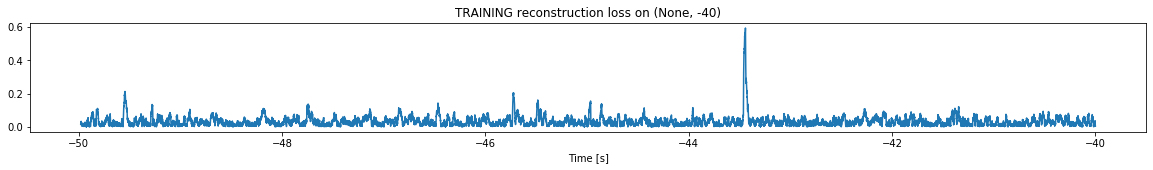

Finished training, median of the log(loss) is:  -1.5812166378674326
<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


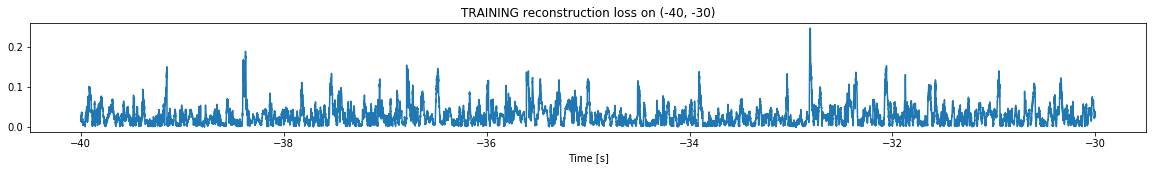

Finished training, median of the log(loss) is:  -1.6562004988717496
Triggering for section:  (-30, -20)
Using this median for triggering: -1.5812166378674326
Triggering threshold is:  3.0


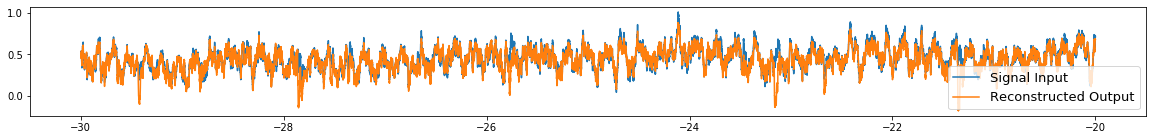

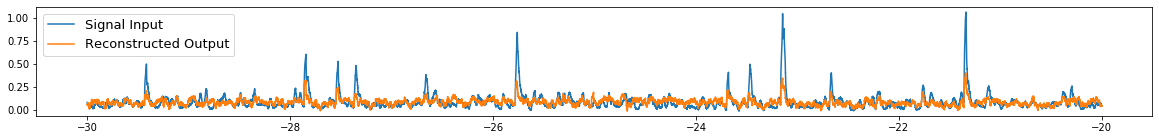

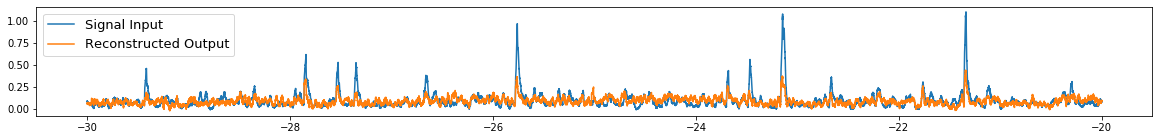

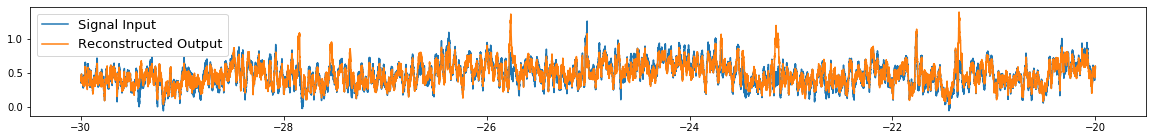

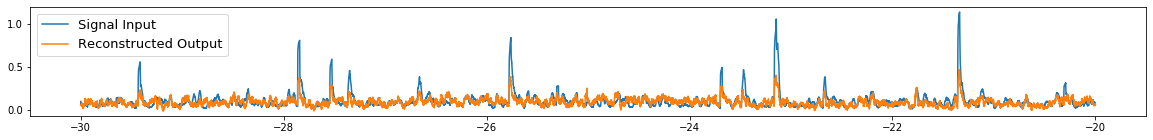

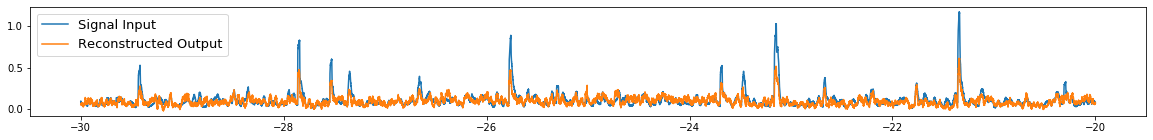

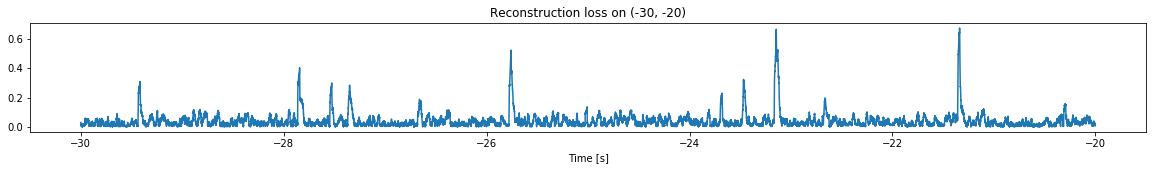

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


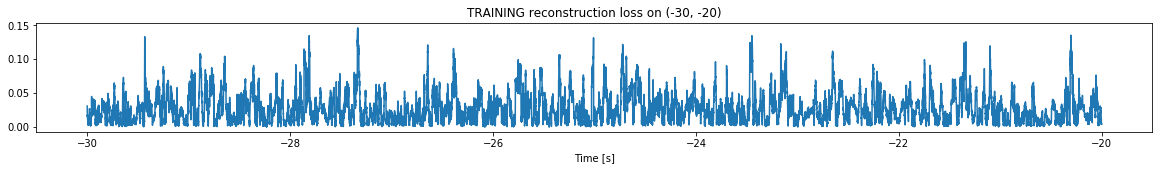

Finished training, median of the log(loss) is:  -1.635531174278936
Triggering for section:  (-20, -10)
Using this median for triggering: -1.6562004988717496
Triggering threshold is:  1.6


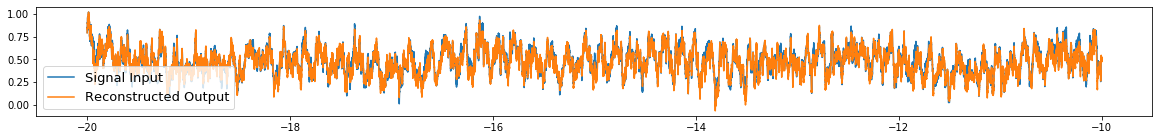

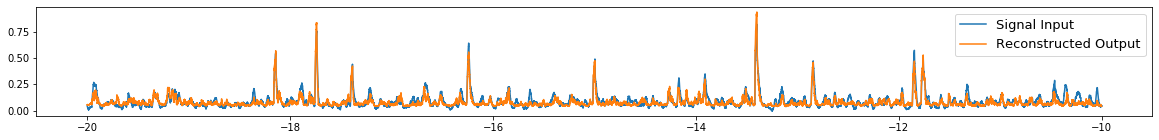

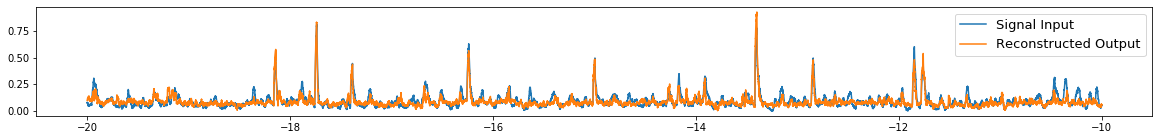

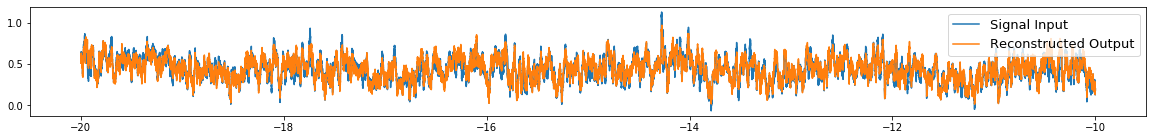

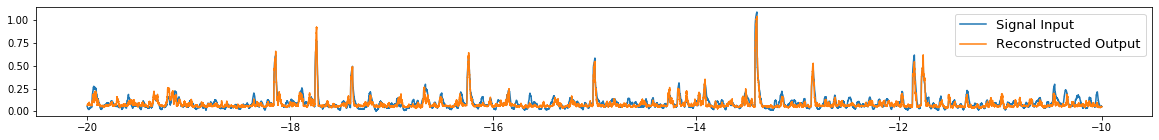

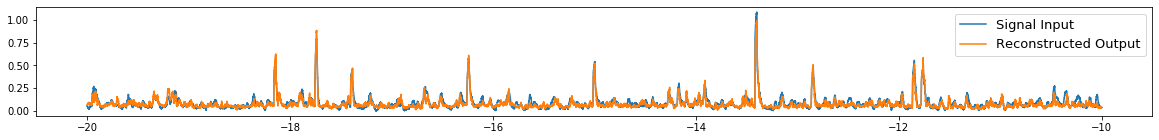

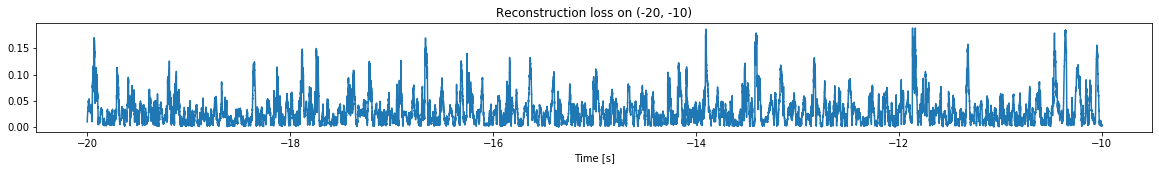

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


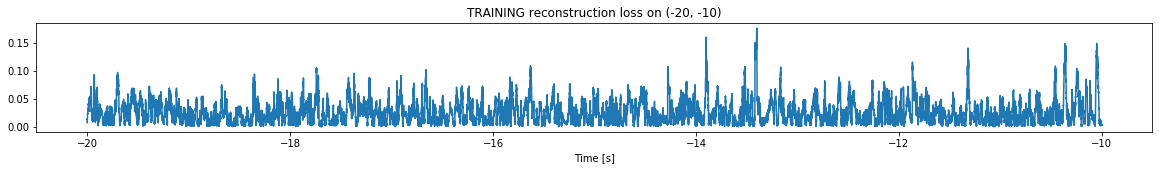

Finished training, median of the log(loss) is:  -1.6704235531451255
Triggering for section:  (-10, 0)
Using this median for triggering: -1.635531174278936
Triggering threshold is:  1.6


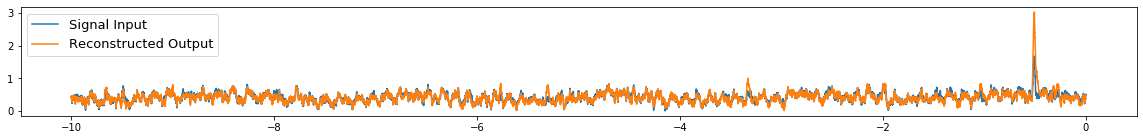

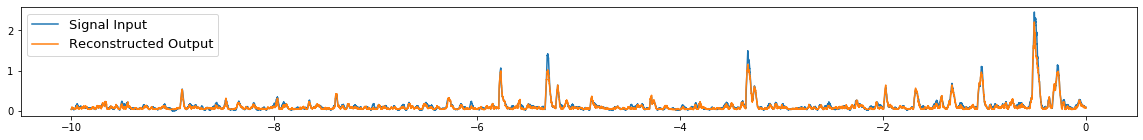

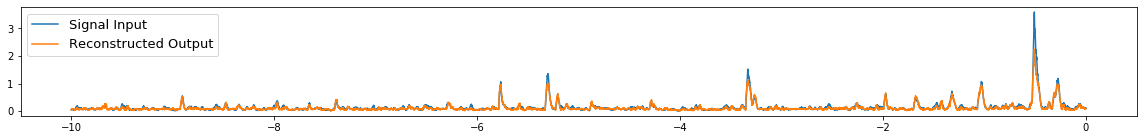

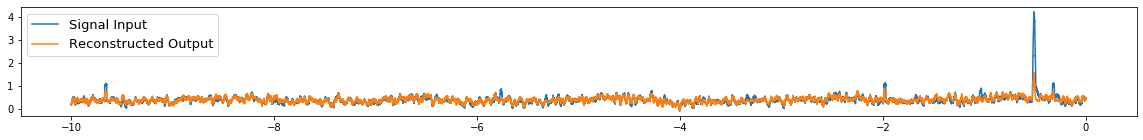

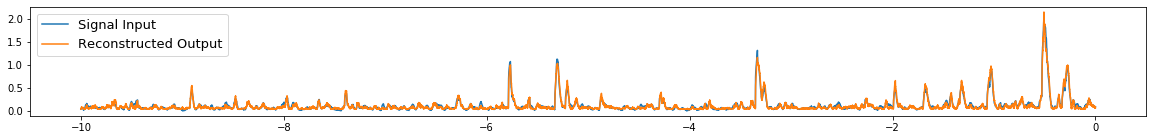

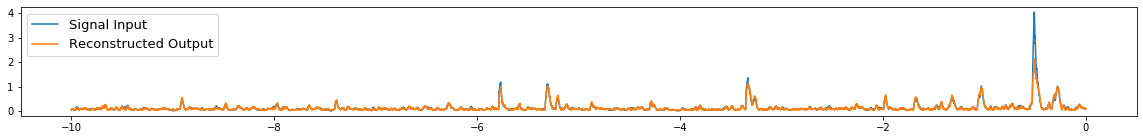

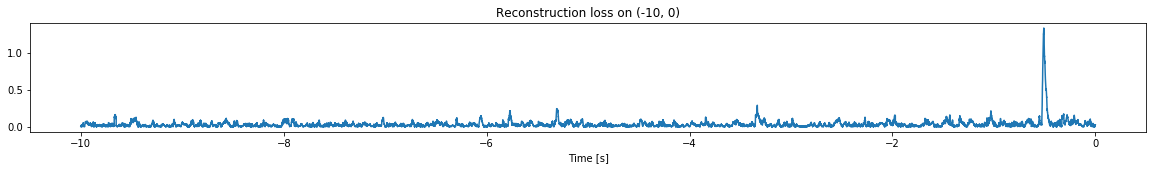

Other trigger time:  [-0.5082]
Their log loss values are:  [1.75974565]


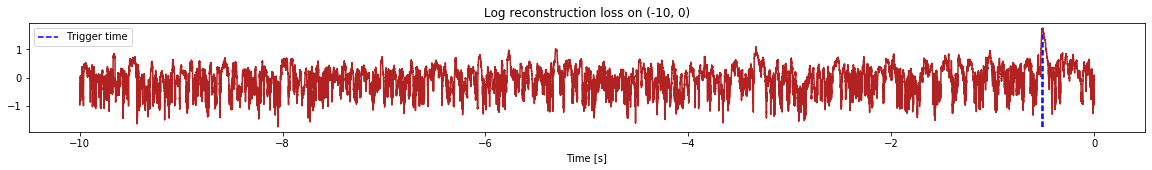

Triggered at:  [-0.5082]
Latent coordinates are:  [[-0.4394763, 7.3943405]]
<--------


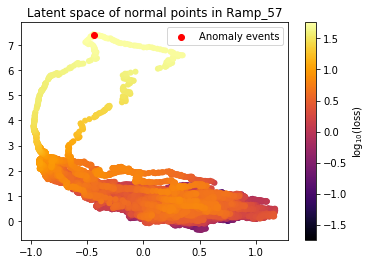

In [2]:
latent_normal_coord, all_test_loss, latent_coor, all_test_loss, time_test  = simulation("Ramp_57", "15T_data", 10,  time_range = (-50,0), reached_max = -1.55)